# Fast Radial Potential

The goal is sum up radial potential function with nice properties such as
  - fast evaluation (e.g. low degree polynominal)
  - finite support (to allow linear scaling N-body simulation)
  - smooth derivatives (1st, 2nd)
  - can be computed from $r^2$ rather than $r$ (so save `sqrt()` in vector lenght evaluation)
  - crucial features such as (1) minimum position (2) minimum energy (3) node position can be easily tuned
  - can be factorized for parir of atoms (therefore it can be stored on grid)


In [112]:
# initialize environment
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
x = np.linspace(0.0,10.0,1000)
dx = x[1]-x[0]

### How to use $|\vec r|^2$ instead of $|\vec r|$ (get rid of `sqrt()`)

$F(\vec r) = {\vec r} (F(r)/r$)

So we have to express $f(r)=F(r)/r$ in terms of only $(r^2)^N$. For example function $F(r) = (1-r^2)$ is not good since $f(r)=(1-r^2)/r$ requires explicit evaluation of $r^{-1}$. But function $F(r) = (1-r^2)*r$ and $F(r) = (1-r^2)/r$ are good since $f(r)=(1-r^2)$ and $f(r)=(1-r^2)/r^2$ can be efficinetly expressed in terms of only $(r^2)^N$. Notice, that for any polynominal radial potential $V(r)$ composed of only $(r^2)^N$ the resulting force ( i.e. derivative $\partial_r r^N = r^{N-1}$ ) always fullfill this condition.

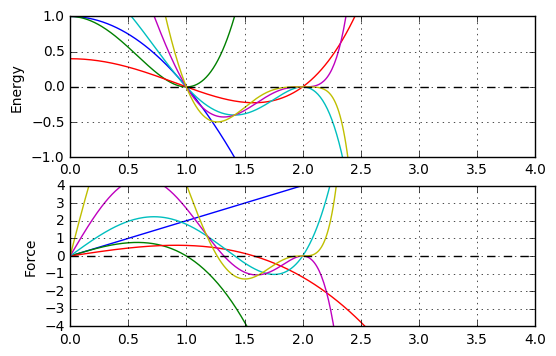

In [26]:
def func1(r):
    r2 = r**2
    E  = 1-r2
    fr = -2
    return E,fr*r

def func2(r):
    r2 = r**2
    E  = (1-r2)**2
    fr  = -2*(1-r2)
    return E,fr*r

def func3(r):
    r2 = r**2
    E  = 0.1*(    (1-r2)*     (4-r2)  )
    fr = 0.1*( -2*(1-r2) + -2*(4-r2)  )
    return E,fr*r

def func4(r):
    r2 = r**2
    E  = 0.1*(    (1-r2)*            (4-r2)**2  )
    fr = 0.1*( -4*(1-r2)*(4-r2) + -2*(4-r2)**2  )
    return E,fr*r

def func5(r):
    r2 = r**2
    E  = 0.05*(    (1-r2)*               (4-r2)**3  )
    fr = 0.05*( -6*(1-r2)*(4-r2)**2 + -2*(4-r2)**3  )
    return E,fr*r

def func6(r):
    r2 = r**2
    E  = 0.025*(    (1-r2)*               (4-r2)**4  )
    fr = 0.025*( -8*(1-r2)*(4-r2)**3 + -2*(4-r2)**4  )
    return E,fr*r

funcs = [func1,func2,func3,func4,func5,func6]
for func in funcs:
    E,F = func(x)
    plt.subplot(2,1,1); plt.plot(x,E);
    plt.subplot(2,1,2); plt.plot(x,-F);

plt.subplot(2,1,1); plt.ylim(-1.0,1.0); plt.xlim(0.0,4.0); plt.grid(); plt.ylabel("Energy"); plt.axhline(0,c='k',ls='--')
plt.subplot(2,1,2); plt.ylim(-4.0,4.0); plt.xlim(0.0,4.0); plt.grid(); plt.ylabel("Force"); plt.axhline(0,c='k',ls='--')


## Factorized Polynominals


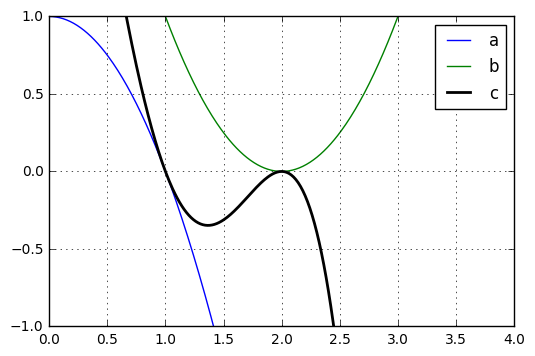

In [27]:
a = (1.0-x**2)   # this per atom
b = (x-2)**2     # this will be on grid
plt.plot(x,a,label='a')
plt.plot(x,b,label='b')
plt.plot(x,a*b,lw=2,c='k',label='c')
vmax=1.00; plt.ylim(-vmax,vmax); plt.xlim(0.0,4.0); plt.grid(); plt.legend()

## Approx exponential

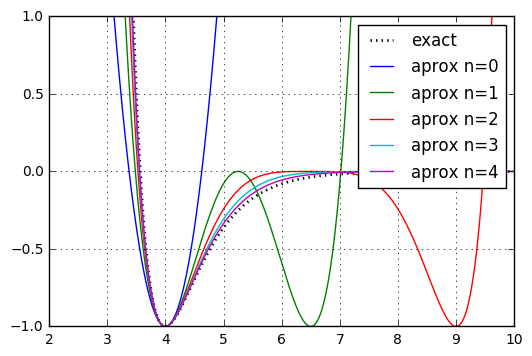

In [28]:
alpha = -1.6

def getMorse( r, R, eps, alpha=alpha ):
    return eps*( np.exp(2*alpha*(r-R)) - 2*np.exp(alpha*(r-R)) )

def fastExp( x, n=4 ):
    e = 1.0 + x/np.power(2.0,n);
    for i in range(n): e*=e
    return e

def getFastMorse( r, R, eps, alpha=alpha, n=4 ):
    expar = fastExp(alpha*(r-R), n=n )
    return eps*( expar*expar - 2*expar )
    
plt.plot( x, getMorse       ( x, 4.0, 1.0 ), ':k', lw=2, label=('exact') )
for i in range(5):
    plt.plot( x, getFastMorse( x, 4.0, 1.0, n=i ), ls='-', label=('aprox n=%i' %i ) )
    
vmax=1.00; plt.ylim(-vmax,vmax); plt.xlim(2.0,10.0); plt.grid(); plt.legend()

### Approx Gaussian

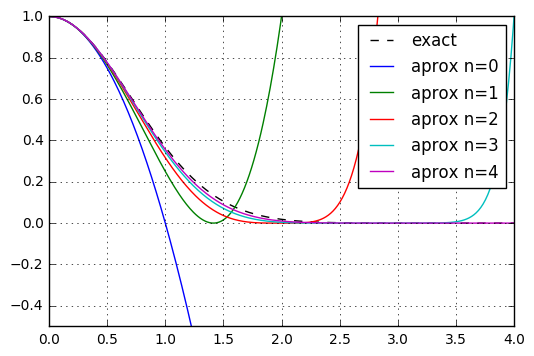

In [29]:
def Gaussian( r ):
    return np.exp(-r*r)

def fastGauss( r, n=4 ):
    x = r*r
    e = 1.0 - x/np.power(2.0,n);
    for i in range(n): e*=e
    return e

plt.plot( x , Gaussian( x), '--k', label=('exact') )
for i in range(5):
    plt.plot( x, fastGauss( x, n=i ), ls='-', label=('aprox n=%i' %i ) )

plt.ylim(-0.5,1.0); plt.xlim(0.0,4.0); plt.grid(); plt.legend()

### Exp power 

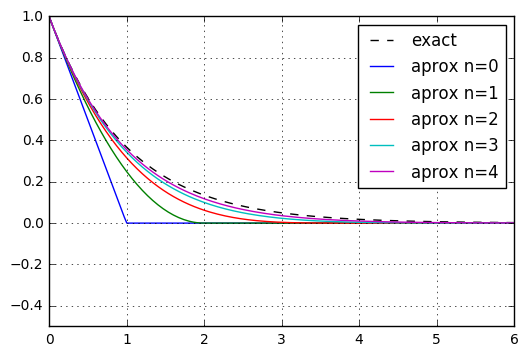

In [30]:
def fastExp( x, n=4 ):
    e = 1.0 + x/np.power(2.0,n);
    e[e<0] = 0
    for i in range(n): e*=e
    return e

xs = np.linspace(0.0,10.0,300)

plt.plot( xs, np.exp(-xs), '--k', label=('exact') )
for i in range(5):
    plt.plot( xs, fastExp(-xs, n=i ), ls='-', label=('aprox n=%i' %i ) )

plt.ylim(-0.5,1.0); plt.xlim(0.0,6.0); plt.grid(); plt.legend()

# Radial polynomynal potential

In [113]:


'''
V  = (A-r2)*(B-r2)**4
fr = ( 4*(A-r2) - (B-r2) )*-2*(B-r2)**3
'''

r, r2, A, B, C = sy.symbols('r r2 A B C')

V = (A-r2)*(B-r2)**2
F = sy.diff(V, r2)
#F = sy.simplify(sy.expand(F))
F = sy.factor(F)
print F
F = F.expand()
print "coefs : "
#print sy.collect(F,r2)
print " ^0 : ",F.coeff(r2, 0)
print " ^1 : ",F.coeff(r2, 1)
print " ^2 : ",F.coeff(r2, 2)
print " ^3 : ",F.coeff(r2, 3)
print " ^4 : ",F.coeff(r2, 4)

print "solve : ", sy.solve(F,r2)

-(-B + r2)*(-2*A - B + 3*r2)
coefs : 
 ^0 :  -2*A*B - B**2
 ^1 :  2*A + 4*B
 ^2 :  -3
 ^3 :  0
 ^4 :  0
solve :  [B, 2*A/3 + B/3]


C= 9.0 n= 2  C*(n+1)= 27.0  B= 16.0
A = 5.5  R0 = 2.34520787991
resc =  0.00583090379009
C= 9.0 n= 3  C*(n+1)= 36.0  B= 19.36
A = 5.54666666667  R0 = 2.35513623102
resc =  0.000260424736303
C= 9.0 n= 4  C*(n+1)= 45.0  B= 23.04
A = 5.49  R0 = 2.34307490277
resc =  7.33203369882e-06


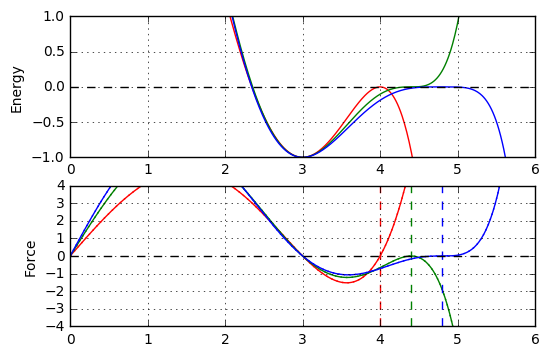

In [86]:
def UniPolyPot( r, Rmax=4.0, Rmin=2.0, n=4):
    '''
    potential in form $ V(r) = (A-r^2) * (B-r^2)^n $
    '''
    r2   = r**2
    C    = Rmin**2
    B    = Rmax**2
    print "C=",C,"n=",n," C*(n+1)=",C*(n+1)," B=",B
    A    = (C*(n+1) - B)/n; print "A =",A," R0 =", np.sqrt(A)
    resc = -1/((A-C)*(B-C)**n);  print "resc = ", resc
    ea   = A-r2
    eb   = B-r2
    ebn  = eb**(n-1) * resc
    E    = ea * eb * ebn
    fr   = ( n*ea + eb) * ebn * 2
    return E, fr*r

def plotUniPolyPot( Rmax=4.0, Rmin=2.0, n=4, clr=None ):
    E,F = UniPolyPot(x, Rmax=Rmax, Rmin=Rmin, n=n )
    plt.subplot(2,1,1); plt.plot(x,E, c=clr, label=("%i" %n));
    plt.subplot(2,1,2); plt.plot(x,F, c=clr, label=("%i" %n));
    plt.plot((x[:-1]+x[1:])*0.5,(E[:-1]-E[1:])/dx, ls=":",c=clr, label=("%i" %n));
    plt.axvline(Rmax,c=clr, ls="--")

plotUniPolyPot( Rmax=4.0, Rmin=3.0, n=2, clr='r' )
plotUniPolyPot( Rmax=4.4, Rmin=3.0, n=3, clr='g' )
plotUniPolyPot( Rmax=4.8, Rmin=3.0, n=4, clr='b' )

plt.subplot(2,1,1); plt.ylim(-1.0,1.0); plt.xlim(0.0,6.0); plt.grid(); plt.ylabel("Energy"); plt.axhline(0,c='k',ls='--')
plt.subplot(2,1,2); plt.ylim(-4.0,4.0); plt.xlim(0.0,6.0); plt.grid(); plt.ylabel("Force"); plt.axhline(0,c='k',ls='--')

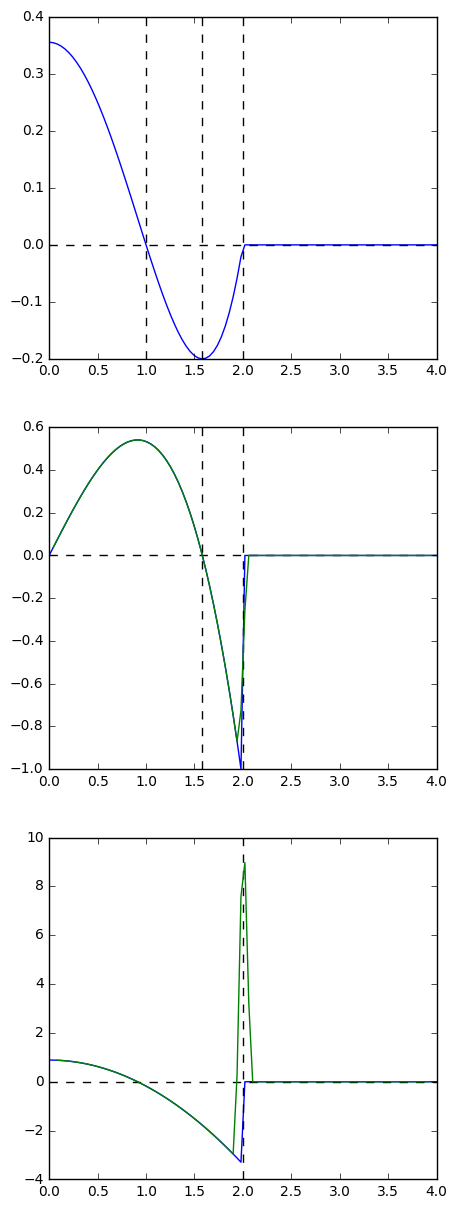

In [31]:
def R4(r,   REmin=2.0, Emin=-0.2, E0=1.0 ):
	REmin2  = REmin**2
	Scaling = (E0-Emin)/(REmin2**2)
	Rmax    = np.sqrt(REmin2+np.sqrt(-(Emin/Scaling)))
	R0      = np.sqrt(REmin2-np.sqrt(-(Emin/Scaling)))
	mask=(r>Rmax)	
	r2=r**2	
	f   = Scaling*( (REmin2-r2)**2    ) + Emin
	df  = Scaling*( 4*(REmin2-r2)*r   )
	ddf = Scaling*( 4*REmin2-12*r2    )
	f[mask]=0; df[mask]=0; ddf[mask]=0;
	return f,df,ddf, Rmax,R0,REmin

def R4_(r,   R0=1.0, Rmax=2.0, Emin=-0.2 ):
	Rmax2=Rmax**2; R02=R0**2
	REmin2  = (Rmax2 + R02)*0.5
	Scaling = -4*Emin/(Rmax2-R02)**2
	mask=(r>Rmax)	
	r2=r**2	
	f   = Scaling*( (REmin2-r2)**2    ) + Emin
	df  = Scaling*( 4*(REmin2-r2)*r   )
	ddf = Scaling*( 4*REmin2-12*r2    )
	f[mask]=0; df[mask]=0; ddf[mask]=0;
	return f,df,ddf, Rmax,R0,np.sqrt(REmin2)

def LR2(r, C=-2.5, K=1.0, A=1.0, s=0.1 ):
	r2=r**2
	f   = K*r2  + A/(s+r2)  +   C
	df  = -( 2*K*r - 2*A*r/(s+r2)**2 )
	ddf = -( 2*K   - 2*A/(s+r2)**2  + 8*A*r2/(s+r2)**3 )
	return f,df,ddf,0,0,0 


rs   = np.linspace(0,4.0,100)
#func = R4
func = R4_
#func = LR2
f,df,ddf, Rmax,R0,REmin  = func(rs)
dr   = rs[1]-rs[0] 
df_  = -(f[2:]-f[:-2])/(2*dr)
ddf_ = (df_[2:]-df_[:-2])/(2*dr)
plt.figure(figsize=(5,15))
plt.subplot(3,1,1); plt.plot(rs,f)   ; plt.axhline(0,ls='--',color='k'); plt.axvline(R0,ls='--',color='k');    plt.axvline(REmin,ls='--',color='k'); plt.axvline(Rmax,ls='--',color='k'); #  plt.ylim(-1,1); 
plt.subplot(3,1,2); plt.plot(rs,df)  ; plt.axhline(0,ls='--',color='k'); plt.axvline(REmin,ls='--',color='k'); plt.axvline(Rmax,ls='--',color='k'); plt.plot(rs[1:-1],df_); #  plt.ylim(-5,5);
plt.subplot(3,1,3); plt.plot(rs,ddf) ; plt.axhline(0,ls='--',color='k'); plt.axvline(Rmax,ls='--',color='k');  plt.plot(rs[2:-2],ddf_); #  plt.ylim(-10,10);
plt.show()

### Even reciprocal polynominal



In [121]:
'''
$ eps*( A/r^8 - 1/r^6) = eps*(R0^2-r^2)/(r^2)^4 $
$ A = R0^2 $
'''

r, r2, A, B, C = sy.symbols('r r2 A B C')

V = (A-r2)/r2**4  # A/r^8
F = sy.diff(V, r2)
#F = sy.simplify(sy.expand(F))
F = sy.factor(F)
print F
print "solve : ", sy.solve(F,r2)

(-4*A + 3*r2)/r2**5
solve :  [4*A/3]


3.0 2.59807621135
2916.0


/home/prokop/.local/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in divide
/home/prokop/.local/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in multiply
/home/prokop/.local/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in divide
/home/prokop/.local/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in multiply


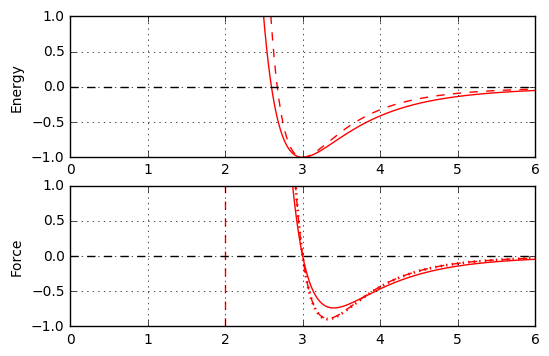

In [179]:
def PolyInvR2( r, Rmin=3.0):
    '''
    '''
    R0    = Rmin*np.sqrt(3.0/4.0)  #*(3.0/4.0)
    print Rmin, R0
    r2    = r**2
    A     = R0**2
    ir2   = 1.0/r2;
    resc  = -1.0/( (1/Rmin**8)*( A-Rmin**2 ) ); print resc
    E     = resc*(ir2**4)*( A-r2 )
    fr    = resc*(ir2**4)*(4*A*ir2-3)*2
    return E, fr*r

def LenardLones( r, Rmin ):
    r2   = r**2
    ir2  = Rmin**2/r2
    ir6  = ir2**3 
    resc = 1.0
    E    = resc*( ir6 - 2 )*ir6
    fr   = resc*( ir6 - 1 )*ir6*ir2*(2.0**(1.0/2.5)) # WHY ?
    return E, fr*r

def plotPolyInvR2( Rmin=3.0, clr=None ):
    E,F = PolyInvR2(x, Rmin=Rmin )
    E_,F_ = LenardLones( x, Rmin=Rmin )
    plt.subplot(2,1,1); plt.plot(x,E, c=clr);  plt.plot(x,E_, c=clr, ls='--');
    plt.subplot(2,1,2); plt.plot(x,F, c=clr);  plt.plot(x,F_, c=clr, ls='--');
    plt.plot((x[:-1]+x[1:])*0.5,(E_[:-1]-E_[1:])/dx, ls=":", lw=2.0, c=clr);
    plt.axvline(Rmax,c=clr, ls="--")

plotPolyInvR2( Rmin=3.0, clr='r' )
#plotPolyInvR2( , clr='g' )
#plotPolyInvR2( , clr='b' )

plt.subplot(2,1,1); plt.ylim(-1.0,1.0); plt.xlim(0.0,6.0); plt.grid(); plt.ylabel("Energy"); plt.axhline(0,c='k',ls='--')
plt.subplot(2,1,2); plt.ylim(-1.0,1.0); plt.xlim(0.0,6.0); plt.grid(); plt.ylabel("Force"); plt.axhline(0,c='k',ls='--')